In [1]:
# Cell [0]
# ======================================
# 1. Install/Import Required Libraries
# ======================================

import pandas as pd
from google_play_scraper import Sort, reviews
import subprocess
from tqdm import tqdm

In [2]:
# Cell [1]
# ======================================
# 2. Define Parameters
# ======================================

# Package name of the BMW app on Google Play:
app_id = "de.bmw.connected.mobile20.row"

# Ollama model
ollama_model_name = "llama3.2:3b-instruct-fp16"

# Prompt template for sentiment classification.
ollama_prompt_template = """You are a sentiment classifier. Classify the sentiment of the following text as Positive, Negative, or Neutral. Do not add any additional information.
Text: "{review_text}"
Answer:
"""

In [3]:
# Cell [2]
# ======================================
# 3. Fetch Reviews from Google Play Store
# ======================================

# Define languages to fetch (just language codes and labels)
languages = [
    ('en', 'English'),
    ('de', 'German'),
    ('fr', 'French'),
    ('it', 'Italian'),
    ('es', 'Spanish'),
    ('nl', 'Dutch'),
    ('sv', 'Swedish'),
    ('da', 'Danish'),
    ('no', 'Norwegian'),
    ('fi', 'Finnish'),
    ('pl', 'Polish'),
    ('cs', 'Czech'),
    ('pt', 'Portuguese'),
    ('zh', 'Chinese'),
    ('ja', 'Japanese'),
    ('ko', 'Korean'),
    ('ar', 'Arabic'),
    ('tr', 'Turkish'),
    ('ru', 'Russian'),
    ('he', 'Hebrew'),
    ('th', 'Thai'),
    ('vi', 'Vietnamese'),
    ('hi', 'Hindi'),
    ('el', 'Greek'),
    ('hu', 'Hungarian'),
    ('ro', 'Romanian'),
    ('sk', 'Slovak'),
    ('bg', 'Bulgarian'),
    ('hr', 'Croatian'),
    ('sr', 'Serbian'),
    ('uk', 'Ukrainian'),
    ('id', 'Indonesian'),
    ('ms', 'Malay'),
    ('fa', 'Persian'),
    ('ur', 'Urdu'),
    ('bn', 'Bengali'),
    ('ta', 'Tamil'),
    ('te', 'Telugu'),
    ('ml', 'Malayalam'),
    ('et', 'Estonian'),
    ('lv', 'Latvian'),
    ('lt', 'Lithuanian'),
    ('sl', 'Slovenian')
]

# Initialize empty list to store all reviews
all_reviews = []

# Fetch reviews for each language
for lang_code, lang_label in languages:
    continuation_token = None
    prev_length = len(all_reviews)
    
    while True:
        result, continuation_token = reviews(
            app_id,
            lang=lang_code,
            sort=Sort.NEWEST,
            count=100,
            continuation_token=continuation_token
        )
        
        # Add language label to each review
        for review in result:
            review['language'] = lang_label
        
        all_reviews.extend(result)
        
        # Break if no more reviews or if number of reviews isn't increasing
        current_length = len(all_reviews)
        if not continuation_token or current_length - prev_length < 100:
            break
            
        prev_length = current_length

# Convert all reviews into a pandas DataFrame
df = pd.DataFrame(all_reviews)

print("\nReview Statistics:")
print("=" * 50)
print(f"Total number of reviews collected: {len(df)}")
print("\nBreakdown by language:")
print("-" * 50)
language_counts = df['language'].value_counts()
print(language_counts)
print("-" * 50)
print(f"Number of languages with reviews: {len(language_counts)}")
# Inspect the first few rows
df.head()


Review Statistics:
Total number of reviews collected: 17892

Breakdown by language:
--------------------------------------------------
language
German        4814
English       4518
French        1650
Italian       1287
Dutch          941
Spanish        938
Polish         626
Portuguese     562
Russian        465
Romanian       274
Swedish        255
Norwegian      199
Japanese       197
Finnish        170
Czech          153
Greek          113
Hungarian      111
Danish         101
Thai            96
Croatian        62
Turkish         57
Slovak          56
Slovenian       52
Chinese         46
Bulgarian       42
Arabic          30
Serbian         19
Ukrainian       13
Lithuanian      12
Estonian         9
Latvian          7
Indonesian       6
Korean           4
Hebrew           4
Malay            2
Persian          1
Name: count, dtype: int64
--------------------------------------------------
Number of languages with reviews: 36


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,language
0,25f553ca-212c-425f-aeac-67f3eb80bb7a,Chris Webster,https://play-lh.googleusercontent.com/a/ACg8oc...,Great APP with plenty of information available...,3,0,5.3.0,2025-02-28 16:07:49,None,NaT,5.3.0,English
1,344a086c-7ad6-475f-b470-731e51f1a460,Apipu Kamnerdnakta,https://play-lh.googleusercontent.com/a-/ALV-U...,I tried to connect my series5 with the app on ...,2,0,5.3.0,2025-02-28 14:09:43,None,NaT,5.3.0,English
2,63d62c00-0d6a-409a-9dc8-fd17f9f76ce5,Jazz Seahra,https://play-lh.googleusercontent.com/a/ACg8oc...,"remote services widget, half the picture of th...",5,0,5.3.0,2025-02-28 13:14:09,None,NaT,5.3.0,English
3,35221154-4be2-4273-a070-75514fce8646,Andy Len,https://play-lh.googleusercontent.com/a-/ALV-U...,"Easy to navigate, faster response and greater ...",5,0,4.11.5,2025-02-28 01:45:17,None,NaT,4.11.5,English
4,476c6412-e070-4143-a186-6fe50b6399c1,Ivaylo Yakobliev,https://play-lh.googleusercontent.com/a-/ALV-U...,App not update for 2 weeks,3,0,5.3.0,2025-02-27 19:31:59,None,NaT,5.3.0,English


In [4]:
# Cell [3]
# ======================================
# 4. Sample Reviews
# ======================================
# After creating the initial DataFrame, add this line to sample 500 random reviews
df2 = df.sample(n=500, random_state=42)  # random_state ensures reproducibility
print(f"Sampled {len(df2)} random reviews for analysis")

Sampled 500 random reviews for analysis


In [5]:
# Cell [4]
# ======================================
# 5. Translate Non-English Reviews
# ======================================

def translate_text(text, source_lang, ollama_model_name):
    """
    Translate text to English using Ollama.
    
    :param text: Text to translate
    :param source_lang: Source language label (e.g., 'German', 'French')
    :param ollama_model_name: Name of the Ollama model to use
    :return: Translated text
    """
    prompt = f"""You are a translator. Translate the following {source_lang} text to English.
Only provide the translation, no additional information.
Text: "{text}"
Translation:"""
    
    process = subprocess.run(
        ["ollama", "run", ollama_model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    return process.stdout.strip()

# Create a copy of the original content
df2['content_english'] = df2['content']

# Translate non-English reviews
for idx in tqdm(df2[df2['language'] != 'English'].index, desc="Translating reviews"):
    original_text = df2.loc[idx, 'content']
    source_lang = df2.loc[idx, 'language']
    
    translated_text = translate_text(original_text, source_lang, ollama_model_name)
    df2.loc[idx, 'content_english'] = translated_text

# Display a few examples of translated reviews
print("\nExample translations:")
print(df2[['language', 'content', 'content_english']].head(3))

Translating reviews: 100%|██████████| 373/373 [06:53<00:00,  1.11s/it]


Example translations:
     language                                            content  \
290   English  I like to share my poor user experience about ...   
4061  English                It never connect to my car f10 2015   
3827  English  Une application légère et efficace remplacée p...   

                                        content_english  
290   I like to share my poor user experience about ...  
4061                It never connect to my car f10 2015  
3827  Une application légère et efficace remplacée p...  


In [6]:
# Cell [5]
# ======================================
# 6. Display Translation Results
# ======================================

# Set display options to show full content
pd.set_option('display.max_colwidth', None)  # Show full column content
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.width', None)         # Don't wrap to new lines

# Print rows 6000 to 6010 with specified columns
print(df2[['language', 'content', 'content_english']].head(10))

# Reset display options to default (optional)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

         language  \
290       English   
4061      English   
3827      English   
10742      French   
15965  Portuguese   
9482       French   
2232      English   
5937       German   
9506       French   
5639       German   

                                                                                                                                                                                                                                                            content  \
290          I like to share my poor user experience about the app. I had my car service completed two months ago. The maintenance records was updated on my iDrive. But, it couldn't synchronize on My BMW app in which the items is still showing as outstanding.   
4061                                                                                                                                                                                                                            It never connect t

In [9]:
# Cell [6]
# ======================================
# 7. Define Sentiment Analysis Function
# ======================================

def get_sentiment_from_ollama(text, model_name=ollama_model_name):
    
    # Use the English translation for non-English reviews
    text_to_analyze = text['content_english'] if isinstance(text, pd.Series) else text
    
    # Prepare the prompt by injecting our text into the template
    prompt = ollama_prompt_template.format(review_text=text_to_analyze)
    
    # Use subprocess.run to call Ollama
    process = subprocess.run(
        ["ollama", "run", model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    # Ollama's output is in process.stdout
    output = process.stdout.strip()

    return output

In [10]:
# Cell [7]
# ======================================
# 8. Run Sentiment Analysis
# ======================================

# Print total number of reviews before starting
total_reviews = len(df2)
print(f"Starting sentiment analysis on {total_reviews} reviews...")

sentiments = []
for idx, row in tqdm(df2.iterrows(), 
                     desc="Analyzing Sentiment", 
                     total=total_reviews,
                     position=0):
    sentiment_label = get_sentiment_from_ollama(row)
    sentiments.append(sentiment_label)
    
    # Print progress every 100 reviews
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{total_reviews} reviews")

# Add the sentiments to the DataFrame
df2['sentiment'] = sentiments

# Print final count
print(f"\nCompleted sentiment analysis on {len(sentiments)} reviews")

Starting sentiment analysis on 500 reviews...


Analyzing Sentiment:   8%|▊         | 42/500 [00:08<01:16,  5.96it/s]

Processed 6000/500 reviews


Analyzing Sentiment:  10%|▉         | 49/500 [00:09<01:28,  5.07it/s]

Processed 14500/500 reviews


Analyzing Sentiment:  12%|█▏        | 58/500 [00:11<01:16,  5.78it/s]

Processed 9000/500 reviews


Analyzing Sentiment:  31%|███▏      | 157/500 [00:28<00:56,  6.12it/s]

Processed 17500/500 reviews


Analyzing Sentiment:  71%|███████   | 353/500 [01:02<00:28,  5.17it/s]

Processed 8900/500 reviews


Analyzing Sentiment:  91%|█████████ | 453/500 [01:19<00:07,  6.14it/s]

Processed 15600/500 reviews


Analyzing Sentiment: 100%|██████████| 500/500 [01:27<00:00,  5.70it/s]



Completed sentiment analysis on 500 reviews


Sentiment Distribution:
sentiment
Negative     224
Positive     202
Neutral       73
Negative.      1
Name: count, dtype: int64


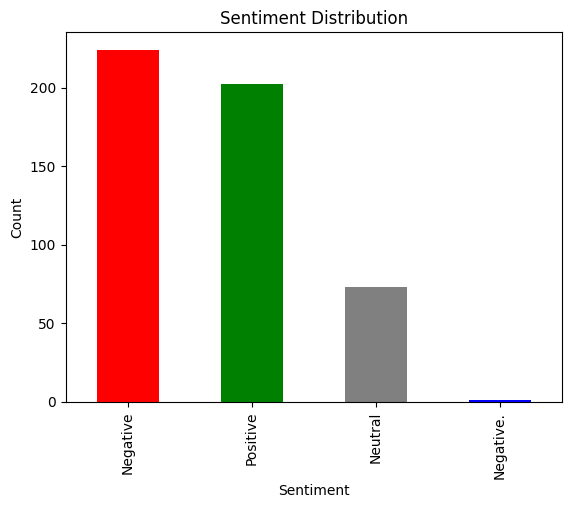

In [11]:
# Cell [8]
# ======================================
# 9. Analyze Sentiment Distribution
# ======================================

# Count how many times each sentiment occurs
sentiment_counts = df2['sentiment'].value_counts()

print("Sentiment Distribution:")
print(sentiment_counts)

# Define a color map for each sentiment
sentiment_color_dict = {
    "Positive": "green",
    "Negative": "red",
    "Neutral": "gray"
}

# Create a list of colors
color_list = [sentiment_color_dict.get(label, "blue") for label in sentiment_counts.index]

# Create the bar plot
ax = sentiment_counts.plot(
    kind='bar', 
    title='Sentiment Distribution', 
    xlabel='Sentiment', 
    ylabel='Count',
    color=color_list
)

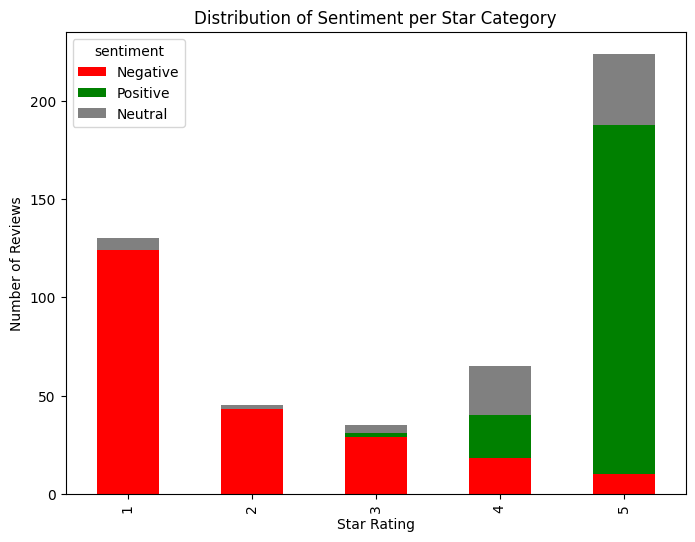

In [12]:
# Cell [9]
# ======================================
# 10. Plot Sentiment per Star Rating
# ======================================

import matplotlib.pyplot as plt

# Group by 'score' (star rating) and 'sentiment', then count how many reviews
grouped = df2.groupby(['score', 'sentiment']).size().unstack(fill_value=0)

# Reorder the columns
column_order = ['Negative', 'Positive', 'Neutral']
grouped = grouped.reindex(columns=column_order, fill_value=0)

# Plot as a stacked bar chart
ax = grouped.plot(
    kind='bar', 
    stacked=True, 
    figsize=(8, 6),
    title='Distribution of Sentiment per Star Category',
    color=color_list
)

ax.set_xlabel('Star Rating')
ax.set_ylabel('Number of Reviews')

plt.show()

In [13]:
# Cell [10]
# ======================================
# 11. Analyze One-Star Reviews
# ======================================

import subprocess

def summarize_complaints(text, ollama_model_name):

    prompt = f"""You are a helpful assistant.
The following text contains users' complaints about a mobile application.
Please provide a concise summary of the main issues that users are complaining about.
Text:
{text}
Summary:"""
    
    process = subprocess.run(
        ["ollama", "run", ollama_model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    return process.stdout.strip()

# Filter 1-star reviews
one_star_df = df2[df2['score'] == 1].copy()

# Combine all 1-star reviews into a single string
complaints_combined = " ".join(one_star_df['content_english'].tolist())

# Call the summarization function
summary_of_complaints = summarize_complaints(complaints_combined, ollama_model_name)
print("Summary of 1-Star Complaints:\n", summary_of_complaints)

Summary of 1-Star Complaints:
 This text is a collection of negative reviews and complaints about the BMW Connected app, which allows users to connect with their BMW vehicles remotely. The reviews describe various issues with the app, including:

1. Connectivity problems: Many reviewers experience difficulties connecting to their vehicles, either due to technical issues or lack of subscription.
2. Registration and login issues: Some users report that the app requires them to re-register or reset their PIN code every time they try to use it.
3. Inability to add vehicles: A few reviewers mention that the app cannot recognize their BMW vehicle's VIN number, making it impossible to connect with their car.
4. Crashes and freezes: Several users experience crashes and freezes while using the app.
5. Lack of value: Some reviewers feel that the new features in the app do not provide any real benefits and only serve to monitor their usage.
6. Compatibility issues: Only newer cars seem to work wi

In [14]:
# Cell [11]
# ======================================
# 12. Define Topic Categories
# ======================================

# First, let's define our potential topics
REVIEW_TOPICS = """
1. UI/UX:
   - User interface, app design, ease of use, navigation, overall visual appeal.
2. Performance:
   - App speed, crashes, bugs, stability, battery drain.
3. Connectivity:
   - Connection issues, Bluetooth, server problems, integration with external devices.
4. Authentication:
   - Login issues, account problems, multi-factor authentication, session timeouts.
5. Vehicle Status:
   - Battery, fuel, location, diagnostics.
6. Remote Controls:
   - Lock/unlock, climate control, remote start.
7. Trip Planning:
   - Route optimization, scheduling, and related features.
8. Charging Management:
   - Charging status, locating charging stations, scheduling.
9. Map/Navigation:
   - Maps functionality, route planning, GPS accuracy, alternative route suggestions.
10. Mobile Features:
   - Widgets, notifications, mobile-specific interactions, quick-access features.
11. Data & Privacy:
   - Data handling, privacy concerns, data sharing, security practices.
12. Updates:
   - App updates, version issues, patch notes, update-related bugs.
13. Feature Requests:
    - Desired new functionality, user suggestions for enhancements.
14. Customer Support:
    - Support experience, response time, issue resolution, helpdesk effectiveness.
15. Connected Store:
    - In-app store experience, product browsing, payment process, promotional offers, purchase issues, ease of transaction.
16. BMW Digital Premium:
    - Subscription service experience, access to premium features, content quality, subscription pricing, management of subscription settings.
"""

def label_review_topics(text, model_name=ollama_model_name):
    """
    Label a review with relevant topics using Ollama.
    
    :param text: Review text to analyze
    :param model_name: Ollama model name
    :return: List of identified topics
    """
    prompt = f"""You are a review topic classifier. Given the following review, identify ALL relevant topics it discusses.
Use ONLY the topics from this list:
{REVIEW_TOPICS}

Review text: "{text}"

Output the topics as a simple comma-separated list, with no additional text or explanations.
If you are not sure about the topics, output the word "Other". It can be due to the review being too short or unclear, empty or not related to the app.
Example output: UI/UX, Performance, Core Features (Vehicle Status)"""
    
    process = subprocess.run(
        ["ollama", "run", model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    return process.stdout.strip()


In [15]:
# Cell [12]
# ======================================
# 13. Apply Topic Labeling
# ======================================

print("Starting topic analysis...")
topics = []
for idx, row in tqdm(df2.iterrows(), 
                     desc="Analyzing Topics", 
                     total=len(df2),
                     position=0):
    # Use English content for consistency
    review_topics = label_review_topics(row['content_english'])
    topics.append(review_topics)
    
    # Print progress every 100 reviews
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(df2)} reviews")

# Add topics to DataFrame
df2['topics'] = topics

Starting topic analysis...


Analyzing Topics:   8%|▊         | 41/500 [00:18<02:57,  2.58it/s]

Processed 6000/500 reviews


Analyzing Topics:  10%|▉         | 48/500 [00:20<03:08,  2.40it/s]

Processed 14500/500 reviews


Analyzing Topics:  11%|█▏        | 57/500 [00:24<03:53,  1.90it/s]

Processed 9000/500 reviews


Analyzing Topics:  31%|███       | 156/500 [01:06<02:22,  2.41it/s]

Processed 17500/500 reviews


Analyzing Topics:  71%|███████   | 353/500 [02:34<01:00,  2.44it/s]

Processed 8900/500 reviews


Analyzing Topics:  90%|█████████ | 452/500 [03:18<00:16,  2.98it/s]

Processed 15600/500 reviews


Analyzing Topics: 100%|██████████| 500/500 [03:41<00:00,  2.26it/s]


/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_90364/2386333303.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


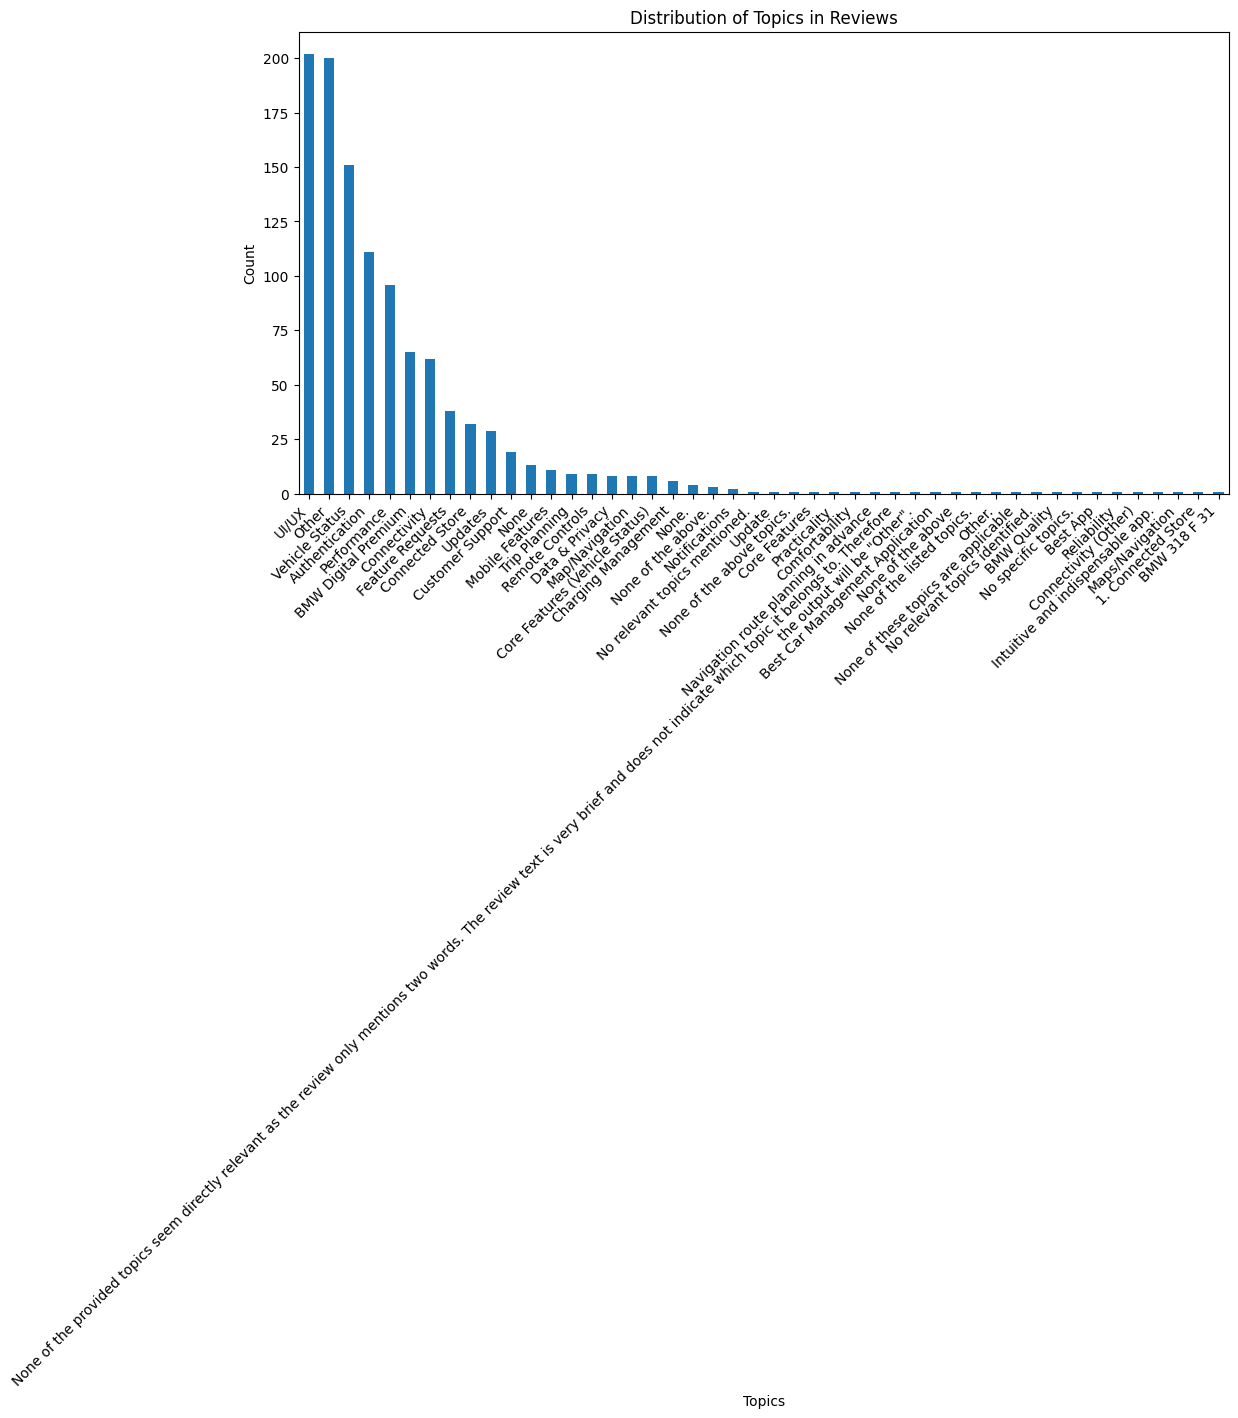

In [16]:
# Cell [13]
# ======================================
# 14. Analyze Topic Distribution
# ======================================

# Split the comma-separated topics and create a flat list
all_topics = []
for topic_list in df2['topics']:
    topics = [t.strip() for t in topic_list.split(',')]
    all_topics.extend(topics)

# Count topic frequencies
topic_counts = pd.Series(all_topics).value_counts()

# Plot topic distribution
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar')
plt.title('Distribution of Topics in Reviews')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_90364/1562212402.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


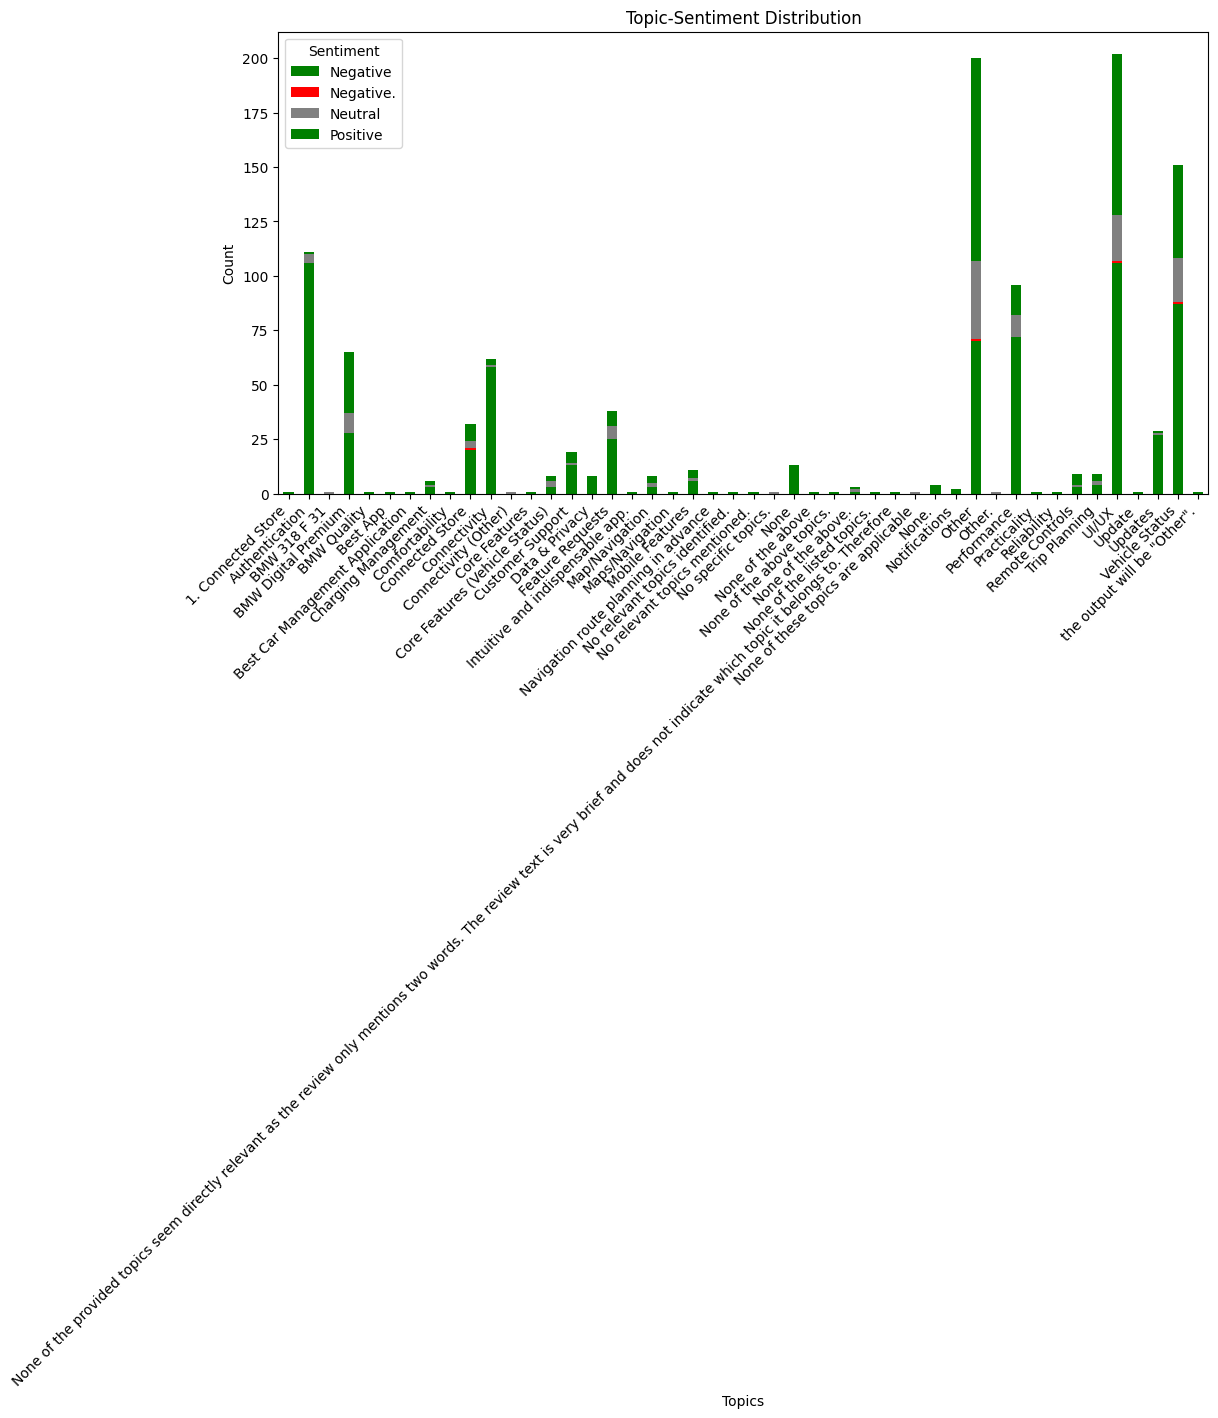

In [17]:
# Cell [14]
# ======================================
# 15. Topic-Sentiment Relationship Analysis
# ======================================

# Create a DataFrame with topic-sentiment combinations
topic_sentiment_data = []
for _, row in df2.iterrows():
    topics = [t.strip() for t in row['topics'].split(',')]
    for topic in topics:
        topic_sentiment_data.append({
            'topic': topic,
            'sentiment': row['sentiment']
        })

topic_sentiment_df = pd.DataFrame(topic_sentiment_data)

# Create a pivot table
topic_sentiment_pivot = pd.pivot_table(
    topic_sentiment_df,
    index='topic',
    columns='sentiment',
    aggfunc='size',
    fill_value=0
)

# Plot stacked bar chart
topic_sentiment_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=['green', 'red', 'gray']
)
plt.title('Topic-Sentiment Distribution')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_90364/2248496748.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  topic_over_time = df2[df2['topics'].str.contains(topic)].resample('M', on='at').size()
/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_90364/2248496748.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  topic_over_time = df2[df2['topics'].str.contains(topic)].resample('M', on='at').size()
/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_90364/2248496748.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  topic_over_time = df2[df2['topics'].str.contains(topic)].resample('M', on='at').size()
/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_90364/2248496748.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  top

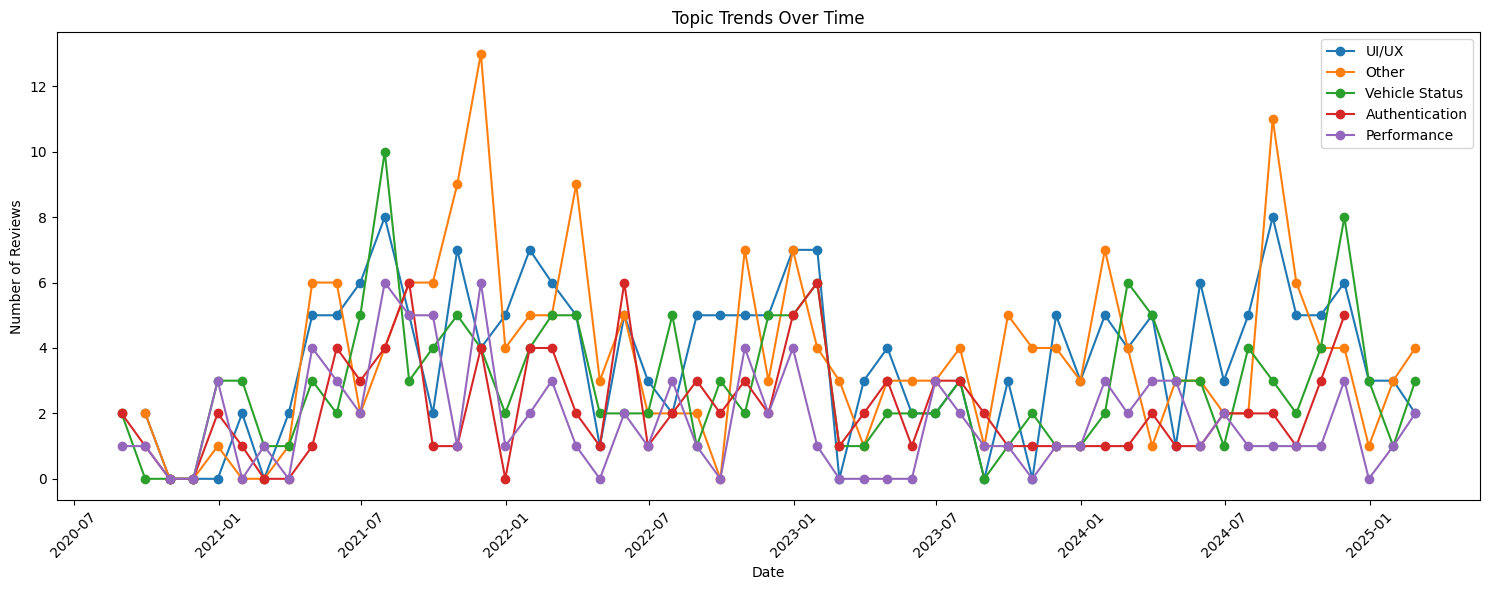

In [18]:
# Cell [15]
# ======================================
# 16. Time-Based Analysis
# ======================================

# Convert 'at' column to datetime if not already
df2['at'] = pd.to_datetime(df2['at'])

# Analyze topic trends over time
def plot_topic_trends():
    # Resample by month and count topics
    monthly_topics = []
    for topic in topic_counts.index[:5]:  # Top 5 most common topics
        topic_over_time = df2[df2['topics'].str.contains(topic)].resample('M', on='at').size()
        monthly_topics.append((topic, topic_over_time))
    
    # Plot
    plt.figure(figsize=(15, 6))
    for topic, data in monthly_topics:
        plt.plot(data.index, data.values, label=topic, marker='o')
    
    plt.title('Topic Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Reviews')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_topic_trends()

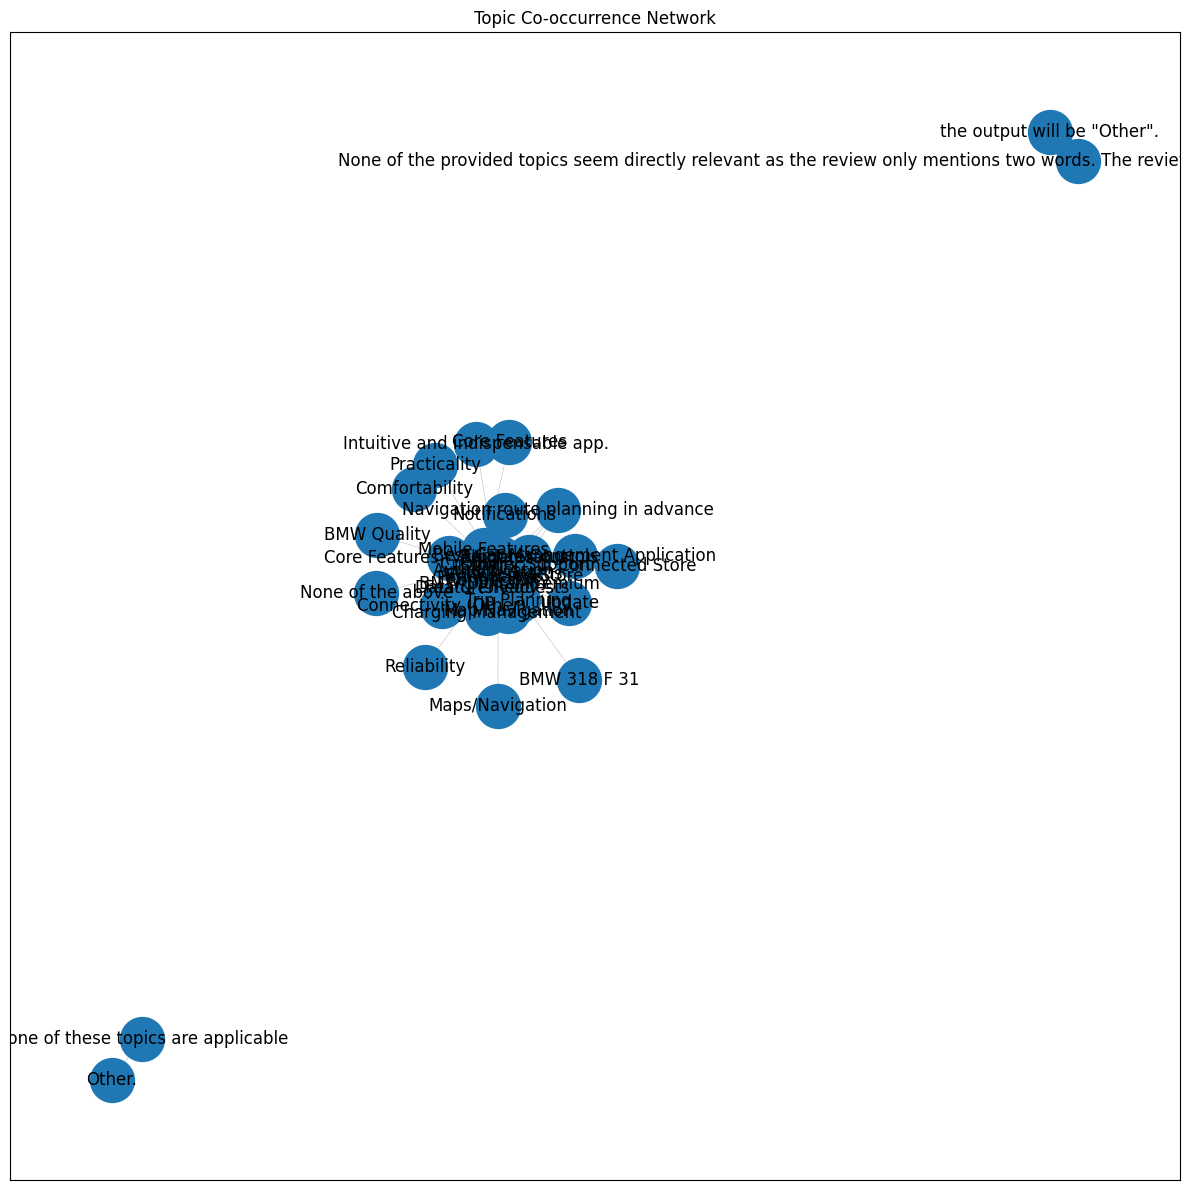

In [19]:
# Cell [16]
# ======================================
# 17. Topic Co-occurrence Analysis
# ======================================

from itertools import combinations
import networkx as nx

def analyze_topic_cooccurrence():
    # Create co-occurrence matrix
    topic_pairs = []
    for topics in df2['topics']:
        topic_list = [t.strip() for t in topics.split(',')]
        topic_pairs.extend(combinations(sorted(set(topic_list)), 2))
    
    cooccurrence = pd.Series(topic_pairs).value_counts()
    
    # Create network graph
    G = nx.Graph()
    for (topic1, topic2), weight in cooccurrence.items():
        G.add_edge(topic1, topic2, weight=weight)
    
    # Plot
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000)
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']/10 for u,v in G.edges()])
    nx.draw_networkx_labels(G, pos)
    plt.title('Topic Co-occurrence Network')
    plt.tight_layout()
    plt.show()

analyze_topic_cooccurrence()

/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_90364/917356870.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(regional_analysis['language'], rotation=45)


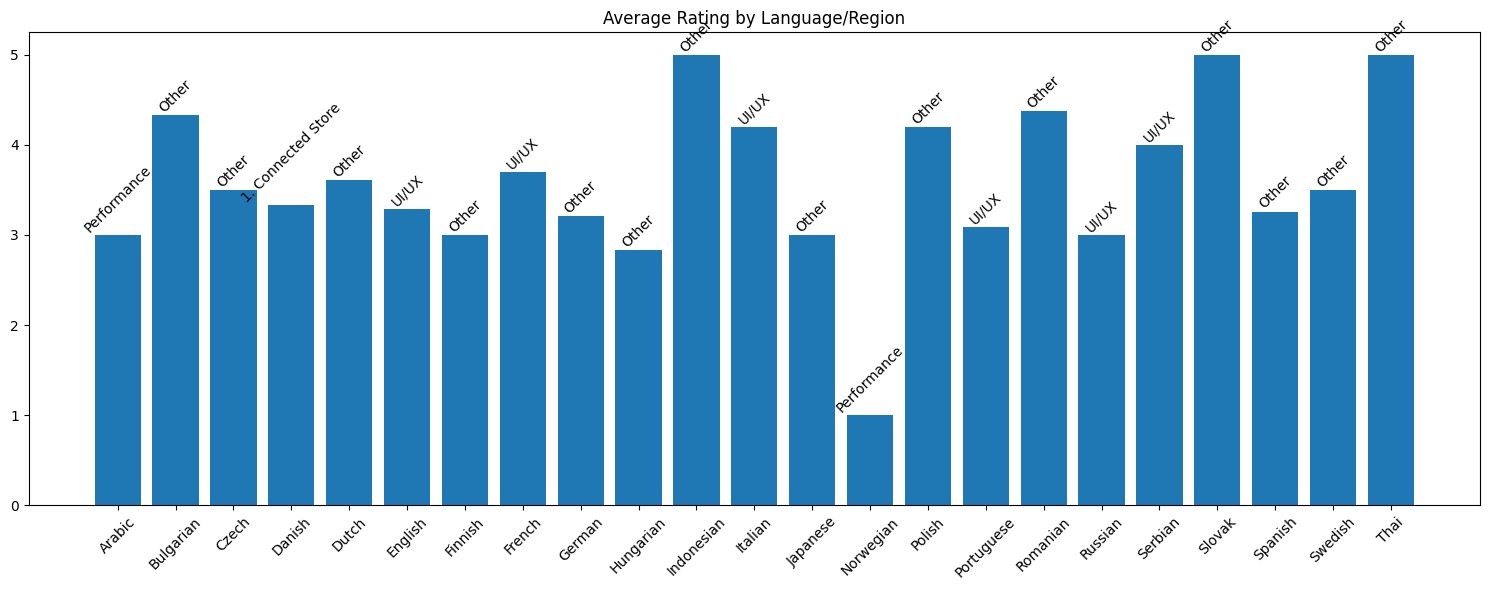

In [20]:
# Cell [17]
# ======================================
# 18. Language/Region Analysis
# ======================================

def analyze_regional_differences():
    # Calculate average ratings and most common topics by language
    regional_analysis = df2.groupby('language').agg({
        'score': 'mean',
        'topics': lambda x: pd.Series([t.strip() for topics in x for t in topics.split(',')]).value_counts().index[0]
    }).reset_index()
    
    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    bars = ax.bar(regional_analysis['language'], regional_analysis['score'])
    ax.set_title('Average Rating by Language/Region')
    ax.set_xticklabels(regional_analysis['language'], rotation=45)
    
    # Add most common topic as text on top of each bar
    for idx, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            regional_analysis.iloc[idx]['topics'],
            ha='center',
            va='bottom',
            rotation=45
        )
    
    plt.tight_layout()
    plt.show()

analyze_regional_differences()

Available columns in df2: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'language', 'content_english', 'sentiment', 'topics']


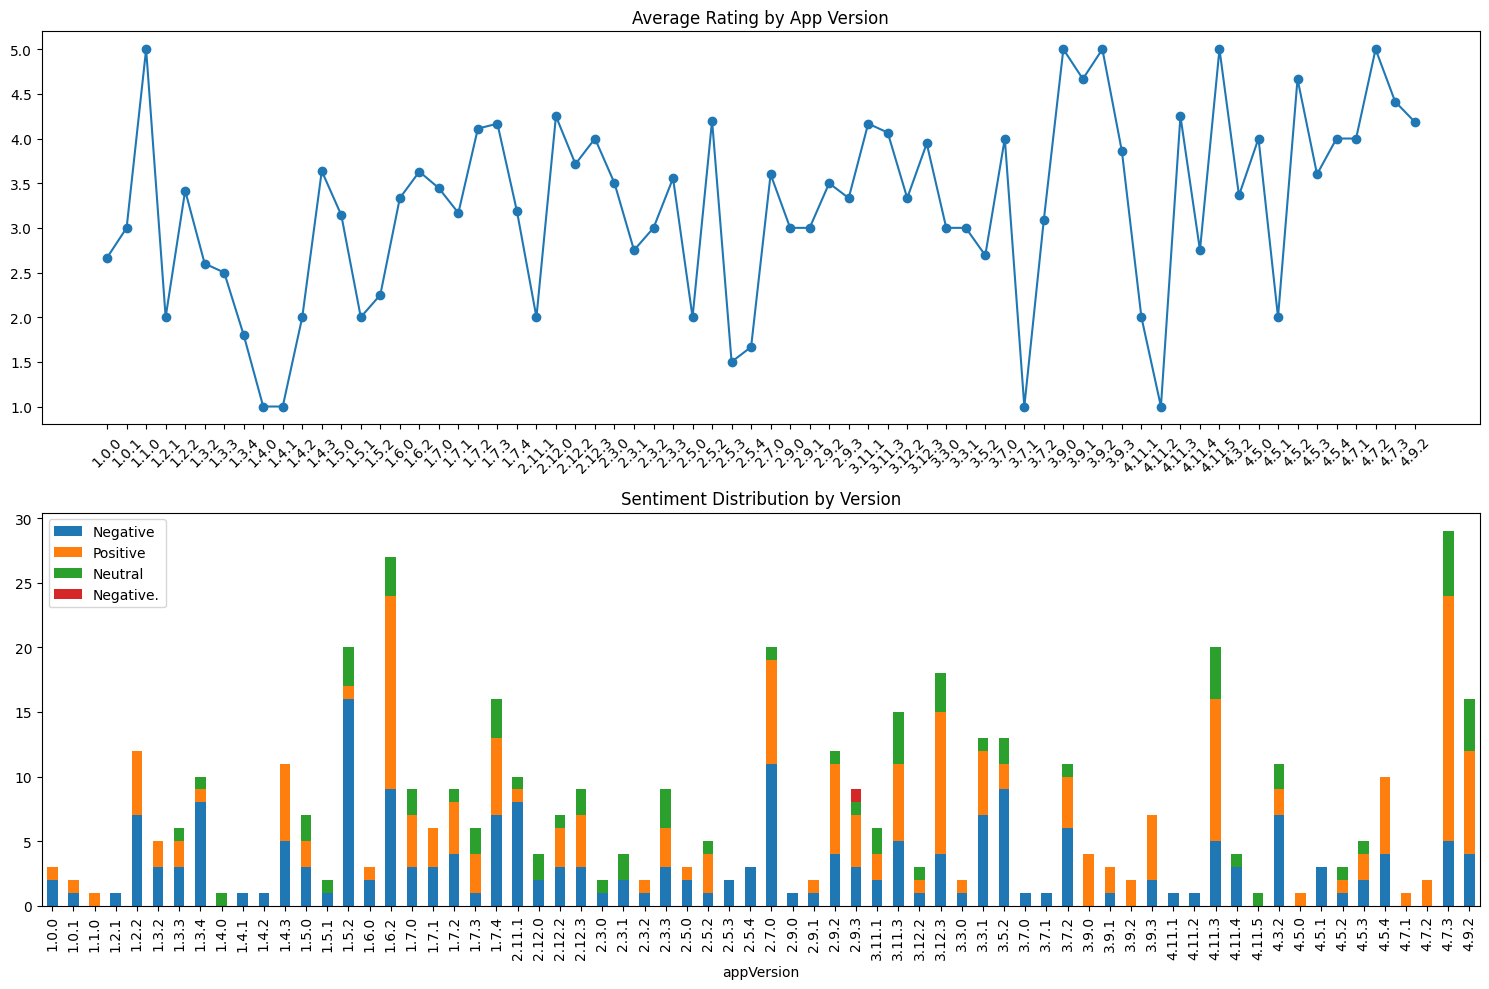

In [21]:
# Cell [18]
# ======================================
# 19. Version-Based Analysis
# ======================================

def analyze_version_impact():
    # First, check if we have version information in the DataFrame
    if 'version' not in df2.columns:
        # Try to use 'appVersion' or other possible column names
        version_column = 'appVersion' if 'appVersion' in df2.columns else None
        if version_column is None:
            print("No version information found in the DataFrame")
            print("Available columns:", df2.columns.tolist())
            return
    else:
        version_column = 'version'

    # Group by version and calculate average score and sentiment distribution
    version_analysis = df2.groupby(version_column).agg({
        'score': 'mean',
        'sentiment': lambda x: x.value_counts().to_dict()
    }).reset_index()
    
    # Sort by version number (assuming semantic versioning)
    version_analysis = version_analysis.sort_values(version_column)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Average score by version
    ax1.plot(version_analysis[version_column], version_analysis['score'], marker='o')
    ax1.set_title('Average Rating by App Version')
    ax1.set_xticks(range(len(version_analysis[version_column])))
    ax1.set_xticklabels(version_analysis[version_column], rotation=45)
    
    # Sentiment distribution by version
    sentiments_by_version = pd.DataFrame([
        {**{version_column: v}, **s}
        for v, s in zip(version_analysis[version_column], version_analysis['sentiment'])
    ]).fillna(0)
    
    sentiments_by_version.plot(x=version_column, kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Sentiment Distribution by Version')
    plt.tight_layout()
    plt.show()

# Let's first check what columns we have in the DataFrame
print("Available columns in df2:", df2.columns.tolist())

analyze_version_impact()

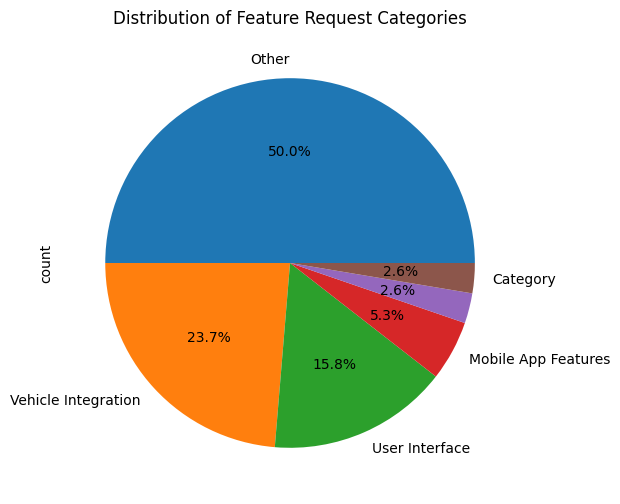


Top Requested Features by Category:

Other:
- The user requests the addition of two features: maximum speed parameter and a built-in route planner to help users navigate back home. (1 requests)
- Request to revert to a previous version of the app due to recent changes that broke functionality and caused user inaccessibility. (1 requests)
- The feature request suggests that an existing service is already offering a comprehensive suite of features at no cost. (1 requests)

User Interface:
- Poor registration and login experience due to error pages after initial setup. (1 requests)
- The feature request reports an issue with starting the diesel heater from the app, which has become non-functional. (1 requests)
- The user is experiencing frustration with the repeated login process at theater updates and the difficulty in resetting their password, particularly when trying to access paid services. (1 requests)

Vehicle Integration:
- The user requests improved re-registration and PIN creati

In [22]:
# Cell [19]
# ======================================
# 20. Feature Request Analysis
# ======================================

def analyze_feature_requests():
    # Filter reviews containing feature requests
    feature_requests = df2[df2['topics'].str.contains('Feature Requests', na=False)]
    
    # Use LLM to categorize and summarize feature requests
    def categorize_feature_request(text, model_name=ollama_model_name):
        prompt = f"""Analyze this feature request and provide a response in exactly this format:
        Category|Summary
        
        Choose category from:
        - Vehicle Integration
        - Mobile App Features
        - Connected Services
        - User Interface
        - Other
        
        The summary should be a one-line description of the request.
        
        Review text: "{text}"
        
        Remember to use exactly one pipe symbol (|) to separate category and summary.
        """
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        response = process.stdout.strip()
        
        # Handle cases where the response doesn't contain a pipe
        if '|' not in response:
            return 'Other', 'Uncategorized request'
            
        try:
            category, summary = response.split('|', 1)  # Split on first pipe only
            return category.strip(), summary.strip()
        except ValueError:
            return 'Other', 'Uncategorized request'
    
    # Apply categorization
    categorized_requests = []
    for _, row in feature_requests.iterrows():
        try:
            category, summary = categorize_feature_request(row['content_english'])
            categorized_requests.append({
                'category': category,
                'summary': summary,
                'original_text': row['content_english']
            })
        except Exception as e:
            print(f"Error processing review: {e}")
            continue
    
    if not categorized_requests:
        print("No feature requests found or all processing failed")
        return
    
    # Create DataFrame and analyze
    request_df = pd.DataFrame(categorized_requests)
    
    # Plot distribution of feature request categories
    plt.figure(figsize=(10, 6))
    request_df['category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Distribution of Feature Request Categories')
    plt.show()
    
    # Display top requested features by category
    print("\nTop Requested Features by Category:")
    for category in request_df['category'].unique():
        print(f"\n{category}:")
        category_requests = request_df[request_df['category'] == category]['summary'].value_counts().head(3)
        for req, count in category_requests.items():
            print(f"- {req} ({count} requests)")

analyze_feature_requests()

In [23]:
# Cell [20]
# ======================================
# 21. User Pain Points Analysis
# ======================================

def analyze_feature_comparisons():
    """Use LLM to analyze how users compare the BMW app with competitors"""
    
    def extract_comparison(text, model_name=ollama_model_name):
        prompt = f"""Analyze this review for any comparisons with other car manufacturer apps.
        Format response as: Competitor|Feature|Comparison
        Where Comparison is either 'Better', 'Worse', or 'Similar'
        
        Review: "{text}"
        
        Only output formatted lines if comparisons are found."""
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        return [line.strip() for line in process.stdout.strip().split('\n') if line.strip()]
    
    # Find reviews mentioning competitors
    competitor_keywords = ['tesla', 'mercedes', 'audi', 'porsche', 'volkswagen', 'vw']
    competitor_reviews = df2[df2['content_english'].str.lower().str.contains('|'.join(competitor_keywords), na=False)]
    
    comparisons = []
    for _, review in competitor_reviews.iterrows():
        try:
            comp_points = extract_comparison(review['content_english'])
            for point in comp_points:
                competitor, feature, comparison = point.split('|')
                comparisons.append({
                    'competitor': competitor.strip(),
                    'feature': feature.strip(),
                    'comparison': comparison.strip()
                })
        except Exception as e:
            continue
    
    if comparisons:
        comp_df = pd.DataFrame(comparisons)
        
        # Visualize comparisons
        plt.figure(figsize=(12, 6))
        comp_pivot = pd.crosstab(comp_df['competitor'], comp_df['comparison'])
        comp_pivot.plot(kind='bar', stacked=True)
        plt.title('Competitive Comparison Analysis')
        plt.xlabel('Competitor')
        plt.ylabel('Number of Comparisons')
        plt.legend(title='Comparison')
        plt.tight_layout()
        plt.show()
        
        # Print detailed feature comparisons
        print("\nDetailed Feature Comparisons:")
        for competitor in comp_df['competitor'].unique():
            print(f"\n{competitor} Comparisons:")
            competitor_features = comp_df[comp_df['competitor'] == competitor]
            print(pd.crosstab(competitor_features['feature'], competitor_features['comparison']))

analyze_feature_comparisons()

Processing 50 negative reviews...
Skipping response with wrong number of parts: Minor|None
Skipping response with wrong number of parts: Minor|None specified

Extracted 133 valid pain points


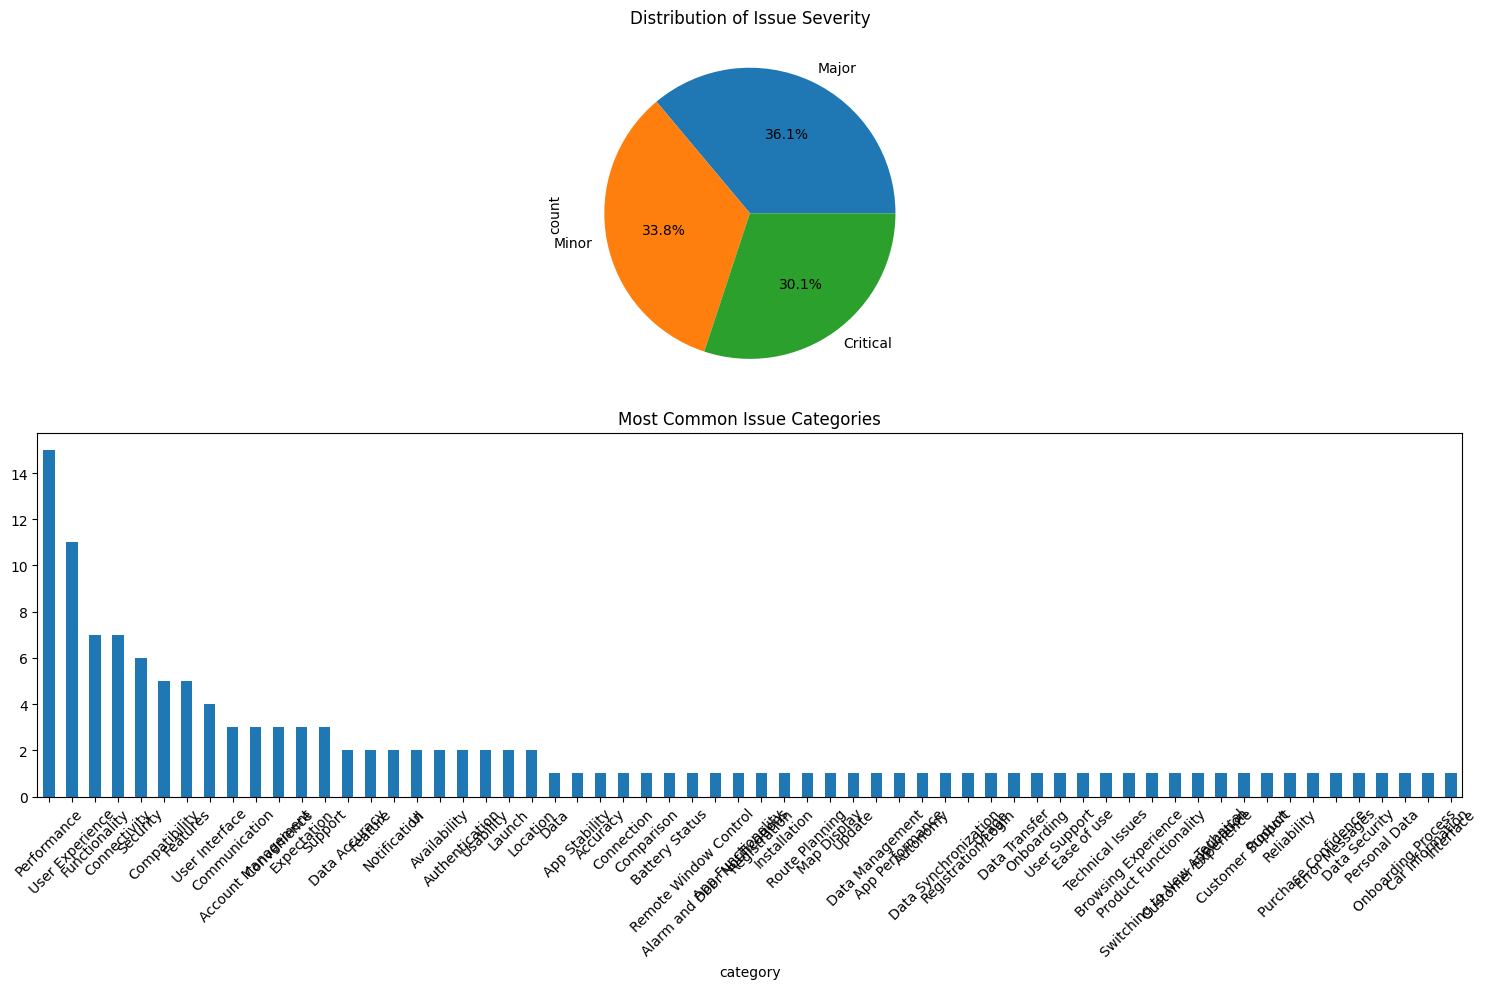


Top Issues by Severity:

Critical Issues:
issue
Device never connects to car's Bluetooth system            1
Application size not optimized for SD card installation    1
Ventilation feature does not work as expected              1
Name: count, dtype: int64

Major Issues:
issue
Maintenance records not syncing between iDrive and BMW app    1
No support for 2015 F10 model year car                        1
App freezes or won't load on device                           1
Name: count, dtype: int64

Minor Issues:
issue
Outstanding status for maintenance items on BMW app    1
App fails to launch from home screen                   1
Application compared unfavorably to old one            1
Name: count, dtype: int64


In [24]:
# Cell [21]
# ======================================
# 22. Pain Points Visualization
# ======================================

def analyze_user_pain_points():
    """Use LLM to identify and categorize specific user pain points"""
    
    def extract_pain_points(text, model_name=ollama_model_name):
        prompt = f"""Analyze this review and identify specific user pain points.
        Format your response as: Severity|Category|Issue
        
        Severity levels: Critical, Major, Minor
        
        Review: "{text}"
        
        If multiple issues exist, list each on a new line.
        Only output the formatted lines, no additional text.
        
        Example output:
        Critical|Performance|App crashes during startup
        Major|Connectivity|Bluetooth connection unstable
        Minor|UI|Text too small to read"""
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        return [line.strip() for line in process.stdout.strip().split('\n') if line.strip()]
    
    # Analyze negative reviews
    negative_reviews = df2[df2['sentiment'] == 'Negative'].head(50)  # Note: 'Negative' not 'negative'
    all_pain_points = []
    
    print(f"Processing {len(negative_reviews)} negative reviews...")
    
    for idx, review in negative_reviews.iterrows():
        try:
            pain_points = extract_pain_points(review['content_english'])
            for point in pain_points:
                # Validate the format
                if '|' not in point:
                    print(f"Skipping invalid response: {point}")
                    continue
                    
                parts = point.split('|')
                if len(parts) != 3:
                    print(f"Skipping response with wrong number of parts: {point}")
                    continue
                    
                severity, category, issue = parts
                
                # Validate severity
                if severity.strip() not in ['Critical', 'Major', 'Minor']:
                    print(f"Skipping response with invalid severity: {severity}")
                    continue
                
                all_pain_points.append({
                    'severity': severity.strip(),
                    'category': category.strip(),
                    'issue': issue.strip()
                })
        except Exception as e:
            print(f"Error processing review: {e}")
            continue
    
    if not all_pain_points:
        print("No valid pain points were extracted from the reviews.")
        return
        
    pain_points_df = pd.DataFrame(all_pain_points)
    print(f"\nExtracted {len(pain_points_df)} valid pain points")
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    severity_counts = pain_points_df['severity'].value_counts()
    severity_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Distribution of Issue Severity')
    
    plt.subplot(2, 1, 2)
    category_counts = pain_points_df['category'].value_counts()
    category_counts.plot(kind='bar')
    plt.title('Most Common Issue Categories')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print top issues by severity
    print("\nTop Issues by Severity:")
    for severity in ['Critical', 'Major', 'Minor']:
        matching_issues = pain_points_df[pain_points_df['severity'] == severity]
        if not matching_issues.empty:
            print(f"\n{severity} Issues:")
            print(matching_issues['issue'].value_counts().head(3))
        else:
            print(f"\nNo {severity} issues found")

analyze_user_pain_points()


=== Competitive Comparison Analysis ===


<Figure size 1200x600 with 0 Axes>

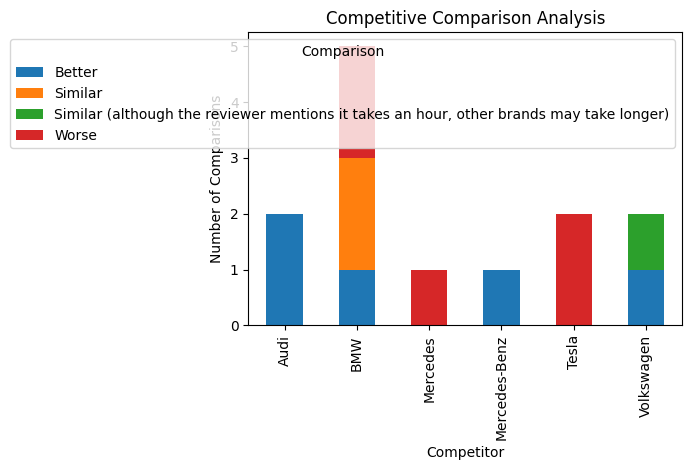


Detailed Feature Comparisons:

Mercedes-Benz Comparisons:
comparison           Better
feature                    
Open Window Feature       1

Tesla Comparisons:
comparison      Worse
feature              
Route Planning      1
Support             1

Volkswagen Comparisons:
comparison   Better  \
feature               
Syncing           1   
Update Time       0   

comparison   Similar (although the reviewer mentions it takes an hour, other brands may take longer)  
feature                                                                                               
Syncing                                                      0                                        
Update Time                                                  1                                        

BMW Comparisons:
comparison            Better  Similar  Worse
feature                                     
App Experience             1        0      0
Ease of Use                0        1      0
Maturity (Years Old) 

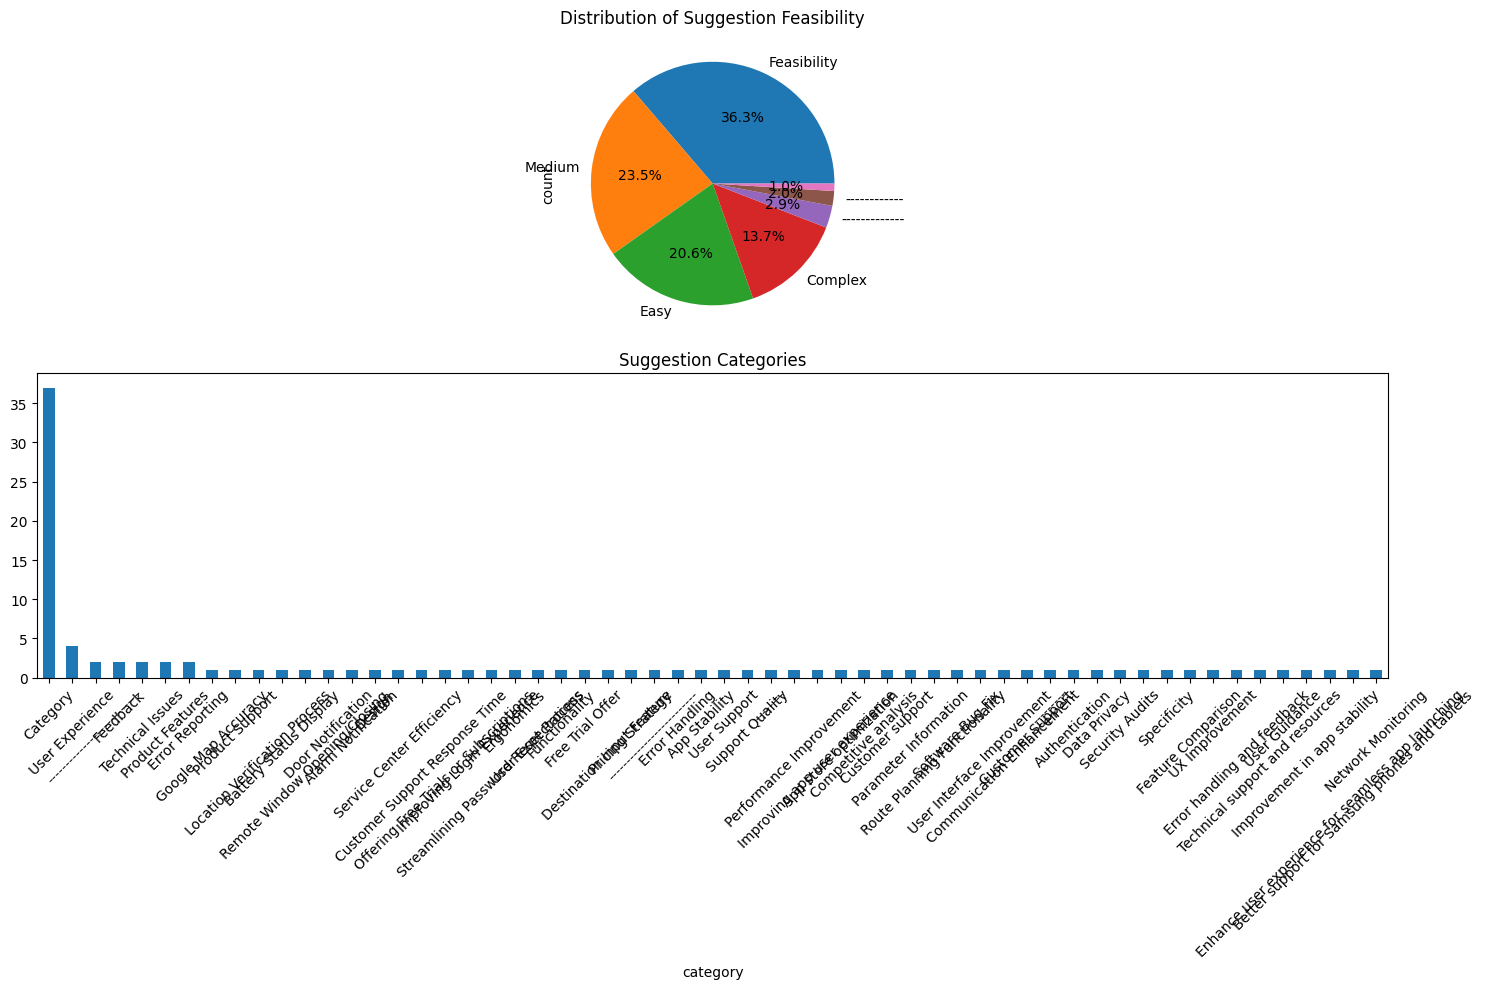


Top Suggestions by Feasibility:

Easy Implementation Suggestions:
suggestion
Optimize the app's visibility in the app stores by improving keywords, description, and screenshots                      1
Enhance user experience by providing clear instructions on how to troubleshoot issues                                    1
Offer a limited free trial period or basic features to incentivize users and allow them to experience the app's value    1
Name: count, dtype: int64

Medium Implementation Suggestions:
suggestion
Enhance user feedback mechanisms to understand client concerns and frustrations                                         1
Implement a customer support system that provides easy access to FAQs, tutorials, and direct contact with developers    1
Implement a retry mechanism for loading cars from the app with failed network connections                               1
Name: count, dtype: int64

Complex Implementation Suggestions:
suggestion
Conduct competitor research to identify 

In [25]:
# Cell [22]
# ======================================
# 23. Competitive Analysis
# ======================================

# Cell [23]
# ======================================
# 24. Improvement Suggestions Analysis
# ======================================
def analyze_feature_comparisons():
    """Use LLM to analyze how users compare the BMW app with competitors"""
    
    def extract_comparison(text, model_name=ollama_model_name):
        prompt = f"""Analyze this review for any comparisons with other car manufacturer apps.
        Format response as: Competitor|Feature|Comparison
        Where Comparison is either 'Better', 'Worse', or 'Similar'
        
        Review: "{text}"
        
        Only output formatted lines if comparisons are found."""
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        return [line.strip() for line in process.stdout.strip().split('\n') if line.strip()]
    
    # Find reviews mentioning competitors
    competitor_keywords = ['tesla', 'mercedes', 'audi', 'porsche', 'volkswagen', 'vw']
    competitor_reviews = df2[df2['content_english'].str.lower().str.contains('|'.join(competitor_keywords), na=False)]
    
    comparisons = []
    for _, review in competitor_reviews.iterrows():
        try:
            comp_points = extract_comparison(review['content_english'])
            for point in comp_points:
                competitor, feature, comparison = point.split('|')
                comparisons.append({
                    'competitor': competitor.strip(),
                    'feature': feature.strip(),
                    'comparison': comparison.strip()
                })
        except Exception as e:
            continue
    
    if comparisons:
        comp_df = pd.DataFrame(comparisons)
        
        # Visualize comparisons
        plt.figure(figsize=(12, 6))
        comp_pivot = pd.crosstab(comp_df['competitor'], comp_df['comparison'])
        comp_pivot.plot(kind='bar', stacked=True)
        plt.title('Competitive Comparison Analysis')
        plt.xlabel('Competitor')
        plt.ylabel('Number of Comparisons')
        plt.legend(title='Comparison')
        plt.tight_layout()
        plt.show()
        
        # Print detailed feature comparisons
        print("\nDetailed Feature Comparisons:")
        for competitor in comp_df['competitor'].unique():
            print(f"\n{competitor} Comparisons:")
            competitor_features = comp_df[comp_df['competitor'] == competitor]
            print(pd.crosstab(competitor_features['feature'], competitor_features['comparison']))

    """Use LLM to analyze and categorize user suggestions for improvement"""


    def extract_suggestions(text, model_name=ollama_model_name):
        prompt = f"""Analyze this review for constructive suggestions for improvement.
        Format response as: Category|Suggestion|Feasibility
        Where Feasibility is 'Easy', 'Medium', or 'Complex'
        
        Review: "{text}"
        
        Only output actionable suggestions, one per line."""
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        return [line.strip() for line in process.stdout.strip().split('\n') if line.strip()]
    
    # Analyze reviews with constructive feedback
    constructive_reviews = df2[df2['content_english'].str.len() > 100]  # Focus on longer reviews
    suggestions = []
    
    for _, review in constructive_reviews.head(50).iterrows():  # Limit to 50 for demo
        try:
            suggs = extract_suggestions(review['content_english'])
            for sugg in suggs:
                category, suggestion, feasibility = sugg.split('|')
                suggestions.append({
                    'category': category.strip(),
                    'suggestion': suggestion.strip(),
                    'feasibility': feasibility.strip()
                })
        except Exception as e:
            continue
    
    if suggestions:
        sugg_df = pd.DataFrame(suggestions)
        
        # Visualize suggestions by feasibility
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 1, 1)
        feasibility_counts = sugg_df['feasibility'].value_counts()
        feasibility_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Distribution of Suggestion Feasibility')
        
        plt.subplot(2, 1, 2)
        category_counts = sugg_df['category'].value_counts()
        category_counts.plot(kind='bar')
        plt.title('Suggestion Categories')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print top suggestions by feasibility
        print("\nTop Suggestions by Feasibility:")
        for feasibility in ['Easy', 'Medium', 'Complex']:
            print(f"\n{feasibility} Implementation Suggestions:")
            feasible_suggs = sugg_df[sugg_df['feasibility'] == feasibility]
            print(feasible_suggs['suggestion'].value_counts().head(3))


print("\n=== Competitive Comparison Analysis ===")
analyze_feature_comparisons()


In [26]:
def generate_comprehensive_analysis_report(df2):
    """
    Generates a comprehensive analysis report with full text display.
    """
    # Set pandas display options
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)

    def format_section(title, content):
        return f"\n{'='*50}\n{title}\n{'='*50}\n{content}\n"
    
    def format_review(row):
        """Format a single review with all its details"""
        return f"""Rating: {row['score']}/5 | Date: {row['at'].strftime('%Y-%m-%d')}
Content: {row['content_english']}"""

    try:
        sections = []
        
        # 1. Executive Summary
        exec_summary = f"""
Analysis Period: {df2['at'].min().strftime('%Y-%m-%d')} to {df2['at'].max().strftime('%Y-%m-%d')}
Total Reviews: {len(df2)}
Overall Rating: {df2['score'].mean():.2f}/5.0

Sentiment Distribution:
---------------------
{df2['sentiment'].value_counts().to_string()}

Rating Distribution:
-----------------
{df2['score'].value_counts().sort_index().to_string()}
"""
        sections.append(format_section("1. EXECUTIVE SUMMARY", exec_summary))
        
        # 2. Sentiment Analysis
        sentiment_analysis = f"""
Average Rating by Sentiment:
-------------------------
{df2.groupby('sentiment')['score'].mean().round(2).to_string()}

Example Reviews by Sentiment:
--------------------------
"""
        for sentiment in ['Positive', 'Negative', 'Neutral']:
            sentiment_reviews = df2[df2['sentiment'] == sentiment].head(3)
            sentiment_analysis += f"\n{sentiment} Reviews (Top 3):\n"
            for _, row in sentiment_reviews.iterrows():
                sentiment_analysis += format_review(row) + "\n\n"
        
        sections.append(format_section("2. SENTIMENT ANALYSIS", sentiment_analysis))
        
        # 3. Topic Analysis
        topics_expanded = df2['topics'].str.split(',').explode()
        topic_counts = topics_expanded.value_counts()
        
        topic_analysis = f"""
Most Common Topics:
----------------
{topic_counts.head(10).to_string()}

Example Reviews by Top Topics:
--------------------------
"""
        for topic in topic_counts.head(5).index:
            topic_reviews = df2[df2['topics'].str.contains(topic, na=False)].head(3)
            topic_analysis += f"\n{topic}:\n"
            for _, row in topic_reviews.iterrows():
                topic_analysis += format_review(row) + "\n\n"
        
        sections.append(format_section("3. TOPIC ANALYSIS", topic_analysis))
        
        # 4. Critical Issues
        negative_reviews = df2[df2['score'] <= 2]
        critical_analysis = f"""
Critical Issues Overview:
----------------------
Total Critical Reviews: {len(negative_reviews)}
Percentage of Total: {(len(negative_reviews)/len(df2)*100):.1f}%

Representative Critical Issues:
---------------------------
"""
        for score in [1, 2]:
            score_reviews = negative_reviews[negative_reviews['score'] == score].head(3)
            critical_analysis += f"\n{score}-Star Reviews:\n"
            for _, row in score_reviews.iterrows():
                critical_analysis += format_review(row) + "\n\n"
        
        sections.append(format_section("4. CRITICAL ISSUES", critical_analysis))
        
        # Combine all sections
        full_report = "\nBMW CONNECTED APP REVIEW ANALYSIS - COMPREHENSIVE REPORT\n" + \
                     f"Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n" + \
                     "".join(sections)
        
        # Save report
        output_file = "bmw_app_comprehensive_analysis_report.txt"
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(full_report)
        
        print(f"Comprehensive report generated and saved to {output_file}")
        return full_report

    except Exception as e:
        print(f"Error generating report: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Generate the comprehensive report
comprehensive_report = generate_comprehensive_analysis_report(df2)

Comprehensive report generated and saved to bmw_app_comprehensive_analysis_report.txt


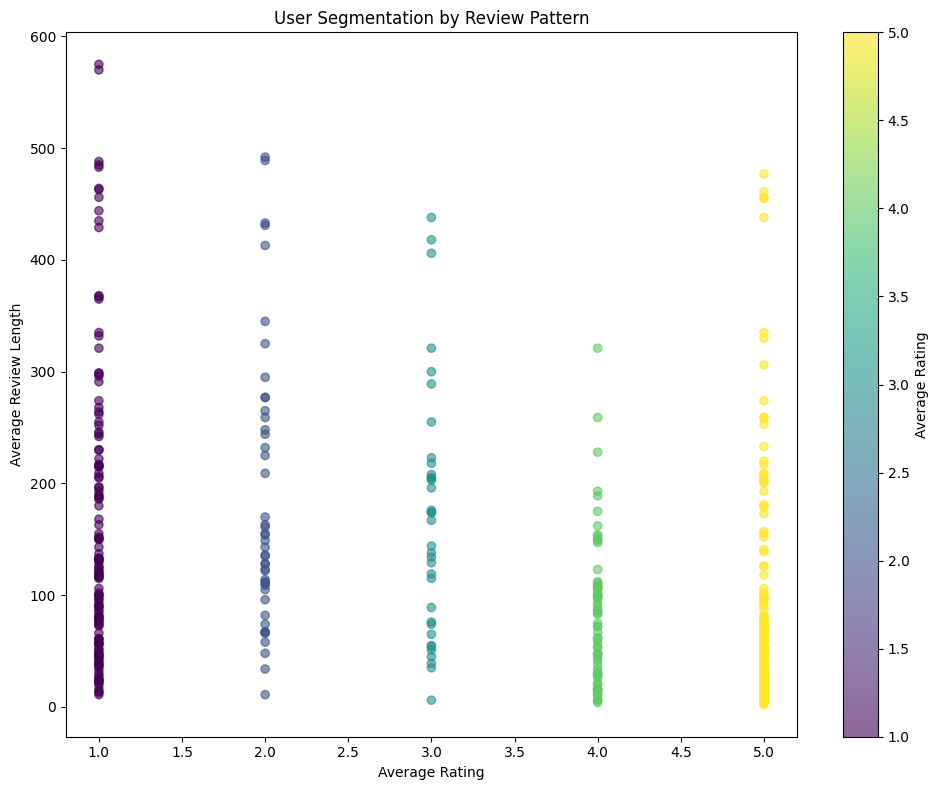

Key User Segments:
1. Detailed Critics: 57
2. Brief Complainers: 63
3. Enthusiastic Supporters: 34
4. Quick Approvers: 134


In [28]:
# ======================================
# NEW SECTION: User Segmentation
# ======================================
import numpy as np

def segment_users():
    """Segment users based on their review patterns"""
    # Create features for clustering
    # - Average rating
    # - Review length
    # - Topic preferences (using one-hot encoding)
    # - Sentiment distribution
    
    # For demonstration, we'll use a simplified approach
    segments = df2.groupby('userName').agg({
        'score': 'mean',
        'content_english': lambda x: np.mean([len(i) for i in x]),
        'sentiment': lambda x: x.value_counts().to_dict()
    }).reset_index()
    
    # Visualize user segments
    plt.figure(figsize=(10, 8))
    plt.scatter(segments['score'], segments['content_english'], 
                alpha=0.6, 
                c=segments['score'], 
                cmap='viridis')
    plt.xlabel('Average Rating')
    plt.ylabel('Average Review Length')
    plt.title('User Segmentation by Review Pattern')
    plt.colorbar(label='Average Rating')
    plt.tight_layout()
    plt.show()
    
    # Identify key user segments
    print("Key User Segments:")
    print("1. Detailed Critics:", len(segments[(segments['score'] < 3) & (segments['content_english'] > 200)]))
    print("2. Brief Complainers:", len(segments[(segments['score'] < 3) & (segments['content_english'] < 100)]))
    print("3. Enthusiastic Supporters:", len(segments[(segments['score'] > 4) & (segments['content_english'] > 100)]))
    print("4. Quick Approvers:", len(segments[(segments['score'] > 4) & (segments['content_english'] < 50)]))

segment_users()

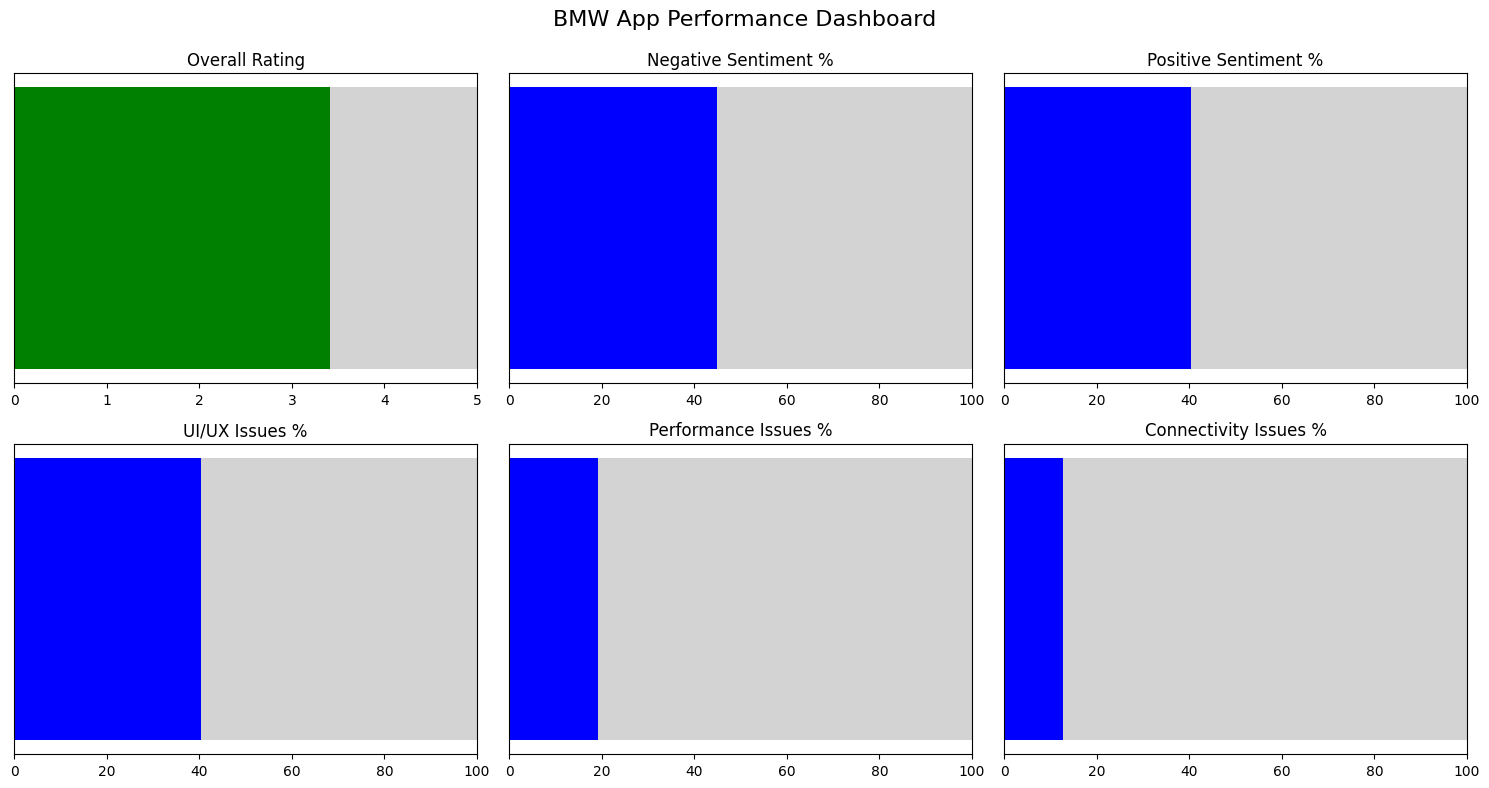

In [29]:
# ======================================
# NEW SECTION: Comparative Performance Metrics
# ======================================

# Define KPIs and metrics to track app performance
def create_performance_dashboard():
    # Calculate key metrics
    metrics = {
        'Overall Rating': df2['score'].mean(),
        'Negative Sentiment %': (df2['sentiment'] == 'Negative').mean() * 100,
        'Positive Sentiment %': (df2['sentiment'] == 'Positive').mean() * 100,
        'UI/UX Issues %': df2['topics'].str.contains('UI/UX').mean() * 100,
        'Performance Issues %': df2['topics'].str.contains('Performance').mean() * 100,
        'Connectivity Issues %': df2['topics'].str.contains('Connectivity').mean() * 100
    }
    
    # Create a dashboard visualization
    fig, ax = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('BMW App Performance Dashboard', fontsize=16)
    
    # Flatten ax for easier iteration
    ax = ax.flatten()
    
    # Create gauge charts or simple bar charts for each metric
    for i, (metric, value) in enumerate(metrics.items()):
        if 'Rating' in metric:
            # For rating (1-5 scale)
            ax[i].barh([''], [value], color='green')
            ax[i].barh([''], [5-value], left=[value], color='lightgray')
            ax[i].set_xlim(0, 5)
        else:
            # For percentage metrics
            ax[i].barh([''], [value], color='blue')
            ax[i].barh([''], [100-value], left=[value], color='lightgray')
            ax[i].set_xlim(0, 100)
            
        ax[i].set_title(metric)
        ax[i].set_yticks([])
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

create_performance_dashboard()

In [30]:
# ======================================
# NEW SECTION: Recommendations Engine
# ======================================

def generate_actionable_recommendations():
    """Generate prioritized recommendations based on the analysis"""
    
    prompt = """Based on the analysis of BMW app reviews, generate 5 prioritized actionable recommendations.
    For each recommendation, include:
    1. The specific issue being addressed
    2. The recommendation details
    3. Expected impact (High/Medium/Low)
    4. Implementation complexity (High/Medium/Low)
    
    Format each recommendation as:
    Issue: [issue]
    Recommendation: [recommendation]
    Impact: [impact]
    Complexity: [complexity]
    
    Issues identified in the reviews include problems with connectivity, authentication, UI/UX, performance, and feature requests.
    """
    
    process = subprocess.run(
        ["ollama", "run", ollama_model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    print("PRIORITIZED RECOMMENDATIONS")
    print("===========================")
    print(process.stdout.strip())

generate_actionable_recommendations()

PRIORITIZED RECOMMENDATIONS
Based on the analysis of BMW app reviews, here are five prioritized actionable recommendations:

1. Issue: Connectivity issues
   Recommendation: Improve network stability and reduce dropped connections by optimizing server-side architecture and client-side caching mechanisms.
   Impact: Medium
   Complexity: Low

2. Issue: Authentication problems
   Recommendation: Enhance authentication security by implementing two-factor authentication (2FA) with push notifications, and improve password reset processes with automated account recovery features.
   Impact: High
   Complexity: Medium

3. Issue: Cluttered UI/UX
   Recommendation: Simplify the navigation menu and reduce visual clutter by introducing a "quick access" tab for frequently used features, and implementing card-based layouts for easier content consumption.
   Impact: Low
   Complexity: Medium

4. Issue: Performance issues (slow loading times)
   Recommendation: Optimize images and assets by compressi

In [31]:
# ======================================
# NEW SECTION: Topic Summaries
# ======================================

def generate_topic_summaries():
    """Generate concise summaries for each identified topic"""
    
    # Extract all unique topics
    all_topics = []
    for topic_list in df2['topics']:
        topics = [t.strip() for t in topic_list.split(',')]
        all_topics.extend(topics)
    
    unique_topics = pd.Series(all_topics).value_counts().index.tolist()
    
    print(f"Generating summaries for {len(unique_topics)} topics...")
    
    topic_summaries = {}
    for topic in tqdm(unique_topics, desc="Processing Topics"):
        # Skip 'Other' category
        if topic.lower() == 'other':
            continue
            
        # Get reviews for this topic
        topic_reviews = df2[df2['topics'].str.contains(topic, na=False)]
        
        # Calculate statistics
        avg_rating = topic_reviews['score'].mean()
        sentiment_dist = topic_reviews['sentiment'].value_counts(normalize=True).to_dict()
        
        # Sample up to 10 reviews for this topic (for LLM context)
        sample_reviews = topic_reviews.sample(min(10, len(topic_reviews)))
        review_texts = sample_reviews['content_english'].tolist()
        
        # Generate summary with LLM
        summary_prompt = f"""You are analyzing user reviews of the BMW Connected app.
Below are several reviews mentioning the topic '{topic}'.

Reviews:
{' '.join([f'"{text}"' for text in review_texts])}

Please provide:
1. A concise summary (3-5 sentences) of what users are saying about this topic
2. The main issues/complaints (if any)
3. The main positive aspects (if any)

Format your response as:
Summary: [summary]
Issues: [issue 1], [issue 2], ...
Positives: [positive 1], [positive 2], ...
"""
        
        process = subprocess.run(
            ["ollama", "run", ollama_model_name],
            input=summary_prompt,
            text=True,
            capture_output=True
        )
        
        # Store results
        topic_summaries[topic] = {
            'summary': process.stdout.strip(),
            'avg_rating': avg_rating,
            'review_count': len(topic_reviews),
            'sentiment_dist': sentiment_dist
        }
    
    # Display summaries in a readable format
    for topic, data in topic_summaries.items():
        print(f"\n{'='*70}")
        print(f"TOPIC: {topic}")
        print(f"{'='*70}")
        print(f"Average Rating: {data['avg_rating']:.2f}/5.0  |  Review Count: {data['review_count']}")
        
        # Format sentiment distribution
        sentiment_str = " | ".join([f"{k}: {v*100:.1f}%" for k, v in data['sentiment_dist'].items()])
        print(f"Sentiment: {sentiment_str}")
        
        print(f"\n{data['summary']}")
    
    return topic_summaries

# Generate and display topic summaries
topic_summaries = generate_topic_summaries()

# Visualize average ratings by topic
topic_ratings = pd.DataFrame([(topic, data['avg_rating']) 
                             for topic, data in topic_summaries.items()], 
                             columns=['Topic', 'Average Rating'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Average Rating', y='Topic', data=topic_ratings.sort_values('Average Rating'))
plt.axvline(x=df2['score'].mean(), color='red', linestyle='--', 
            label=f'Overall Average ({df2["score"].mean():.2f})')
plt.title('Average Rating by Topic')
plt.legend()
plt.tight_layout()
plt.show()

Generating summaries for 46 topics...


Processing Topics:  37%|███▋      | 17/46 [02:16<04:47,  9.92s/it]/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_90364/3042216178.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  topic_reviews = df2[df2['topics'].str.contains(topic, na=False)]
Processing Topics:  89%|████████▉ | 41/46 [03:55<00:14,  2.92s/it]/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_90364/3042216178.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  topic_reviews = df2[df2['topics'].str.contains(topic, na=False)]
Processing Topics: 100%|██████████| 46/46 [04:15<00:00,  5.56s/it]


TOPIC: UI/UX
Average Rating: 3.17/5.0  |  Review Count: 202
Sentiment: Negative: 52.5% | Positive: 36.6% | Neutral: 10.4% | Negative.: 0.5%

Summary: Users are generally satisfied with the ease of use and functionality of the BMW Connected app, but some experience issues with updates, advertisements, registration, and server connectivity problems. The app is praised for its intuitive controls and precise navigation.

Issues:
- Problems with the app crashing or not working properly after an update
- Repeated login prompts from Chrome due to registration issues
- Slow status updates for the car's battery end range
- Limited functionality if only one user is logged in

Positives:
- Easy to use and navigate, especially when controlling the car's climate/heating system
- Provides informative service notifications
- Adds useful features, such as a function to close windows
- Intuitive control and precise navigation of the car

TOPIC: Vehicle Status
Average Rating: 3.02/5.0  |  Review Count:

NameError: name 'sns' is not defined

<Figure size 1200x600 with 0 Axes>

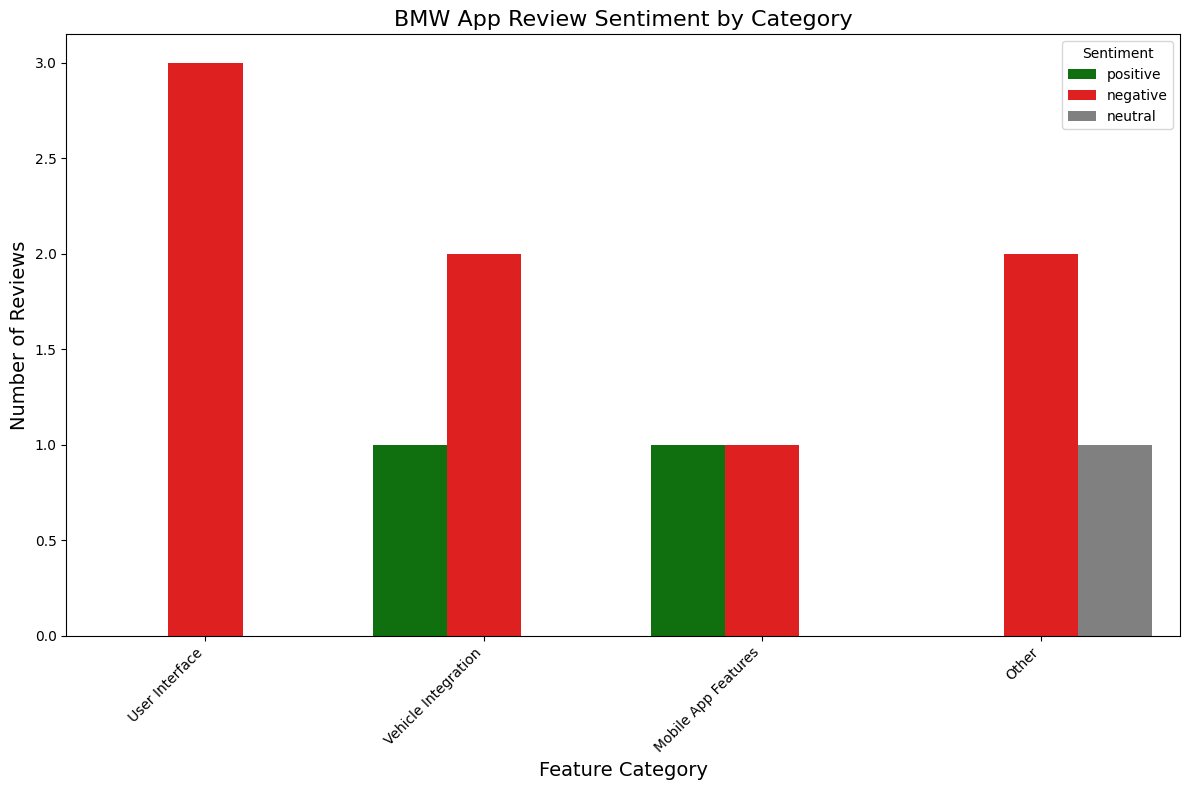

In [2]:
# Assuming you have a DataFrame with 'category' and 'sentiment' columns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame from your existing categorized & sentiment-analyzed data
# Format might be something like:
categories = ['User Interface', 'Vehicle Integration', 'Mobile App Features', 'Other']
sentiment_data = {
    'User Interface': {'positive': 0, 'negative': 3, 'neutral': 0},
    'Vehicle Integration': {'positive': 1, 'negative': 2, 'neutral': 0},
    'Mobile App Features': {'positive': 1, 'negative': 1, 'neutral': 0},
    'Other': {'positive': 0, 'negative': 2, 'neutral': 1}
}

# Transform the data for visualization
viz_data = []
for category, sentiments in sentiment_data.items():
    for sentiment, count in sentiments.items():
        viz_data.append([category, sentiment, count])

df_viz = pd.DataFrame(viz_data, columns=['Category', 'Sentiment', 'Count'])

# Create the visualization
plt.figure(figsize=(12, 8))
chart = sns.barplot(x='Category', y='Count', hue='Sentiment', data=df_viz, palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'})
plt.title('BMW App Review Sentiment by Category', fontsize=16)
plt.xlabel('Feature Category', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

ValueError: Unknown format code 'd' for object of type 'float'

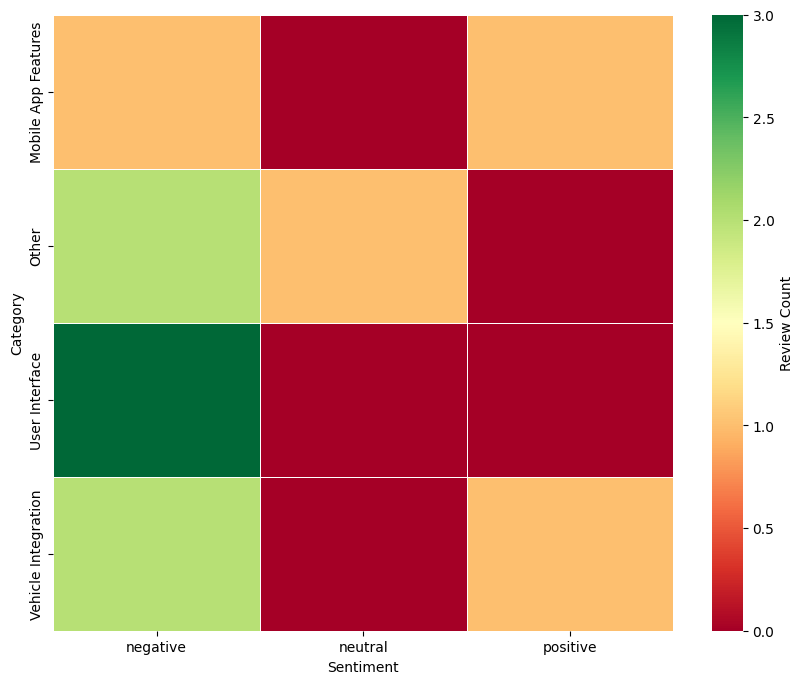

In [3]:
# Create a sentiment heatmap
# Convert data to a matrix form
sentiment_matrix = pd.pivot_table(df_viz, values='Count', index=['Category'], columns=['Sentiment'], fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(sentiment_matrix, annot=True, cmap='RdYlGn', linewidths=.5, fmt='d', cbar_kws={'label': 'Review Count'})
plt.title('Sentiment Distribution Across BMW App Feature Categories', fontsize=16)
plt.tight_layout()
plt.show()

TypeError: Axes.fill_between() missing 1 required positional argument: 'y1'

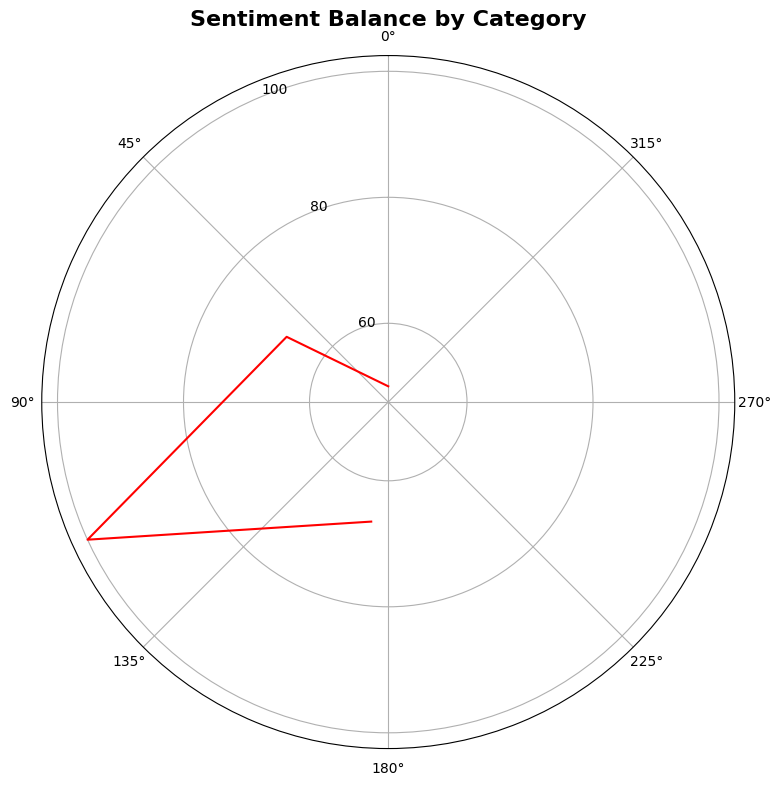

In [4]:
# Create a radar chart to visualize sentiment across categories
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    class RadarAxes(PolarAxes):
        name = 'radar'
        
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')
            
        def fill(self, *args, **kwargs):
            return super().fill_between(*args, **kwargs)
            
        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            return lines
            
    register_projection(RadarAxes)
    fig = plt.figure(figsize=(9, 9))
    
    # Position plots in the center
    ax = fig.add_subplot(1, 1, 1, projection='radar')
    ax.set_rgrids([20, 40, 60, 80, 100])
    ax.set_title('Sentiment Balance by Category', weight='bold', size=16, position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    return fig, ax

# Prepare data for radar chart
categories = sentiment_matrix.index.tolist()
sentiments = sentiment_matrix.columns.tolist()

# Calculate percentages for each category
radar_data = []
for sentiment in sentiments:
    sentiment_percentages = []
    for category in categories:
        total = sentiment_matrix.loc[category].sum()
        percentage = (sentiment_matrix.loc[category, sentiment] / total) * 100 if total > 0 else 0
        sentiment_percentages.append(percentage)
    radar_data.append(sentiment_percentages)

# Plot radar chart
fig, ax = radar_factory(len(categories), frame='polygon')
colors = {'positive': 'g', 'neutral': 'b', 'negative': 'r'}
for sentiment_idx, sentiment in enumerate(sentiments):
    ax.plot(radar_data[sentiment_idx], color=colors[sentiment])
    ax.fill(radar_data[sentiment_idx], alpha=0.1, color=colors[sentiment])
    
ax.set_varlabels(categories)
plt.legend(sentiments, loc=(0.9, .95), labelspacing=0.1)
plt.tight_layout()
plt.show()

In [6]:
# Create a treemap visualization
import plotly.express as px

# Prepare data for treemap
df_viz['Category_Sentiment'] = df_viz['Category'] + " - " + df_viz['Sentiment'].str.capitalize()

fig = px.treemap(
    df_viz, 
    path=['Category', 'Sentiment'], 
    values='Count',
    color='Sentiment',
    color_discrete_map={'positive': 'green', 'neutral': 'gray', 'negative': 'red'},
    title='BMW App Reviews: Categories and Sentiment Distribution'
)
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed